# Objective


# Set up the environment

## Import necessary functions

In [ ]:
%tensorflow_version 2.x

In [43]:
__version__ = '0.1'

In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, Dense, Conv1D, GlobalAveragePooling1D, LSTM, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
print(tf.__version__)

2.2.0


In [ ]:
# Check that we have GPU on
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Download dataset
The original dataset can be downloaded from https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset

To facilitate this Colab sharing, it is made available on a shared Dropbox drive as well

In [ ]:
url = 'https://www.dropbox.com/s/7pokqxeklcc0x69/572515_1037534_bundle_archive.zip?dl=0'

if not (os.path.exists('Fake.csv') and os.path.exists('True.csv')):
  ! wget $url
  ! unzip '/content/572515_1037534_bundle_archive.zip?dl=0'
  ! ls
  ! rm '/content/572515_1037534_bundle_archive.zip?dl=0'


--2020-06-20 11:50:28--  https://www.dropbox.com/s/7pokqxeklcc0x69/572515_1037534_bundle_archive.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.1, 2620:100:6018:1::a27d:301
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/7pokqxeklcc0x69/572515_1037534_bundle_archive.zip [following]
--2020-06-20 11:50:29--  https://www.dropbox.com/s/raw/7pokqxeklcc0x69/572515_1037534_bundle_archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf6f7b793fbedf93a729bf7969f.dl.dropboxusercontent.com/cd/0/inline/A6B8-XIzBEfxDD6VnkdOx8L906KNfgaX1wfi9uhQ59jIdMfo6ZRHXGgh8ocktsSAbkMJZciEs9FZ3_g4ytp2OHny-012eKEOsgMLDhDFv_K9mdf7vGuN4bzAwHtNzC_cIB8/file# [following]
--2020-06-20 11:50:29--  https://ucf6f7b793fbedf93a729bf7969f.dl.dropboxusercontent.com/cd/0/inline/A6B8-XIzBEfxDD6VnkdOx8L906KNfgaX1wfi9uhQ59jIdM

# Preprocessing and initial EDA of the data

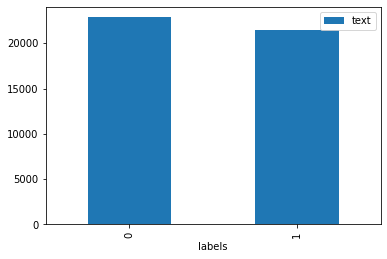

Fake news data: 22855
True news data: 21416


In [ ]:
df_fake = pd.read_csv('Fake.csv')
df_true = pd.read_csv('True.csv')

# We use binary labels:
# 0: Fake
# 1: True
df_fake['labels'] = 0
df_true['labels'] = 1

# Remove rows where the text column is an empty string
df_fake.drop(df_fake[df_fake['text'] == ' '].index, inplace=True)
df_true.drop(df_true[df_true['text'] == ' '].index, inplace=True)

df = pd.concat([df_fake, df_true])
df.groupby('labels').count().plot(kind='bar', y='text')
plt.show()
print(f'Fake news data: {len(df_fake)}')
print(f'True news data: {len(df_true)}')

## Balance the bias
The datasets current are slightly biased with nearly 10% more fake news than true news data points.  To ensure that the output is not skewed because of this imbalance, we will randomly sample.

To make the code more extensible for updates to the data points, we will take the minimum of either data sets, and fractional sample both.

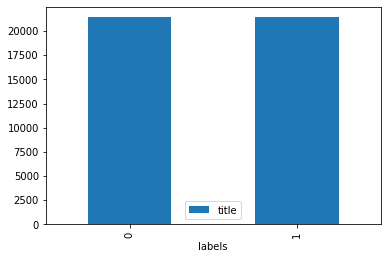

Fake news data: 21416
True news data: 21416


In [ ]:
n_samples = min(len(df_fake), len(df_true))

df_fake = df_fake.sample(n_samples)
df_true = df_true.sample(n_samples)

df = pd.concat([df_fake, df_true])
df.groupby('labels').count().plot(kind='bar', y='title')
plt.show()
print(f'Fake news data: {len(df_fake)}')
print(f'True news data: {len(df_true)}')

## For this training model, we ignore the effects of the title, subject, and date.  We only keep the text.

In [ ]:
# Obtain the train and test sets
features = df['text']
labels = df['labels']

X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state = 727)

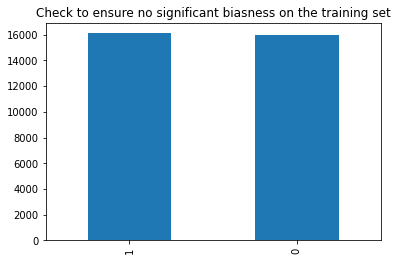

In [ ]:
y_train.value_counts().plot(kind='bar')
plt.title('Check to ensure no significant biasness on the training set')
plt.show()

Although randomly-selected, the output from train_test_split is quite evenly spread


---




## Now we want to combine dataframes, and extract out the text and labels into lists that can be operated on as vectors

In [ ]:
print(f'Training Data: {X_train.shape}')
print(f'Test Data: {X_test.shape}')

Training Data: (32124,)
Test Data: (10708,)


In [ ]:
n = 10
for i in range(n):
  print(f'Label: {y_train.iloc[i]}')
  print(f'{X_train.iloc[i]}')
  print()

Label: 1
SEOUL (Reuters) - North Korean hackers stole a large amount of classified military documents, including South Korea-U.S. wartime operational plans to wipe out the North Korean leadership, a South Korean ruling party lawmaker said on Wednesday. Democratic Party representative Rhee Cheol-hee said 235 gigabytes of military documents were taken from the Defense Integrated Data Center in September last year, citing information from unidentified South Korean defense officials. An investigative team inside the defense ministry announced in May the hack had been carried out by North Korea, but did not disclose what kind of information had been taken. Pyongyang has denied responsibility in its state media for the cyber attacks, criticizing Seoul for  fabricating  claims about online attacks. Separately on Wednesday, cyber security firm FireEye said in a statement North Korea-affiliated agents were detected attempting to phish U.S. electric companies through emails sent in mid-September

# Biasness Observed
I did not discover this myself, but realised it when I read a recent Medium post by Aaron Abrahamson (https://towardsdatascience.com/detecting-fake-news-with-deep-learning-7505874d6ac5).  He was working on a similar problem here, and found the biasness of all real news being taken from Reuters only.

Here we will continue to explore:
1. What is the effect of the biasness on a simplified model (LogisticRegression)
2. What happens if we use a Simple LSTM model

3. What happens if we attempt removing the biasness (only superficially one might add - since removing the word Reuters only does it on the surface.  The style of writing may still contain biasness) - Repeat the experiment using the two methods above.




---


# This is the checkpoint if you want to take in a different dataset
If you want to take in a different data set, you can do so before this point.  You just need to ensure that from this point on, the following variables are defined:

* X_train: pd.Series (text comprising a randomized real/fake text - for 
training)
* X_test: pd.Series (text comprising a randomized real/fake text - for test)
* y_train: pd.Series (0 = False, 1 = True, matching text_train)
* y_test: pd.Series (0 = False, 1 = True, matching text_test)

**Do not use or modify the variables above.  Make copies of it if necessary.  This makes it easier to stack other progressive models without having to break up the codes. **

# Baseline Model - LogisticRegression


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(X_train)

vectors_train = vectorizer.transform(X_train)
vectors_test  = vectorizer.transform(X_test)

The shape of the vectors_train is a 2D matrix.  The rows are the number of documents (in this case, the news articles that is being used), and the columns are the number of words in the vocab.

In [ ]:
print(vectors_train.shape)

(32124, 106273)


In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(verbose=2, max_iter=4000)
classifier.fit(vectors_train, y_train)
score = classifier.score(vectors_test, y_test)

print("Accuracy on test set: ", score)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Accuracy on test set:  0.9952372058274187


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   25.9s finished


In [ ]:
#test_string = [text_train[0]]
test_string_CNN = ["""Brisbane, Australia (CNN)Every day, the men unfurl large pleas for help over the balcony railings of their hotel room and stand in silence as traffic roars along the main road of the Australian city they're trapped in.

Their signs are mostly made from bin bags stuck together with tape, and secured to the railing with shoelaces.
"Where is justice?" one reads.
These men are not hotel guests, but refugees and asylum seekers who have been in Australian immigration custody for seven years. Many arrived in Australian waters in 2013, after the government introduced offshore immigration processing. They were detained on the remote islands of Manus in Papua New Guinea (PNG) and on Nauru in the Pacific, in conditions once described by the United Nations as "harsh" and "inadequate." In 2016, Amnesty International called Nauru an "open-air prison."
"""]

test_string_Reuters = ["""Brisbane, Australia (Reuters)Every day, the men unfurl large pleas for help over the balcony railings of their hotel room and stand in silence as traffic roars along the main road of the Australian city they're trapped in.

Their signs are mostly made from bin bags stuck together with tape, and secured to the railing with shoelaces.
"Where is justice?" one reads.
These men are not hotel guests, but refugees and asylum seekers who have been in Australian immigration custody for seven years. Many arrived in Australian waters in 2013, after the government introduced offshore immigration processing. They were detained on the remote islands of Manus in Papua New Guinea (PNG) and on Nauru in the Pacific, in conditions once described by the United Nations as "harsh" and "inadequate." In 2016, Amnesty International called Nauru an "open-air prison."
"""]

print(test_string_CNN)
print(test_string_Reuters)

test_vector = vectorizer.transform(test_string_CNN)
print(classifier.predict(test_vector))

test_vector = vectorizer.transform(test_string_Reuters)
print(classifier.predict(test_vector))

['Brisbane, Australia (CNN)Every day, the men unfurl large pleas for help over the balcony railings of their hotel room and stand in silence as traffic roars along the main road of the Australian city they\'re trapped in.\n\nTheir signs are mostly made from bin bags stuck together with tape, and secured to the railing with shoelaces.\n"Where is justice?" one reads.\nThese men are not hotel guests, but refugees and asylum seekers who have been in Australian immigration custody for seven years. Many arrived in Australian waters in 2013, after the government introduced offshore immigration processing. They were detained on the remote islands of Manus in Papua New Guinea (PNG) and on Nauru in the Pacific, in conditions once described by the United Nations as "harsh" and "inadequate." In 2016, Amnesty International called Nauru an "open-air prison."\n']
['Brisbane, Australia (Reuters)Every day, the men unfurl large pleas for help over the balcony railings of their hotel room and stand in si

## Observations
The results highlighted the deficiency of using a simplified LogisticRegression model on the training data.  While it was able to fit the train and test data with 99.49% accuracy, it did not work well on test data obtained outside the set.

For example, a recent CNN report was obtained, and the first classification attempt labeled that as a fake news.  Simply switching the phrase CNN to Reuters at the top made it a real news.  

As shown above, most of the training set had the real news simply taken from Reuters.  As a result, the model had most likely fitted itself onto that phrase that differentiate the two.

## Lessons learnt here
* Be careful when using a simple model if the data was biased
* Even though we evened out the data here (number of real and fake news), the source was obtained from just one place (Reuters)


# Improved model using simple LSTM

## Set up word tokenization parameters

In [ ]:
vocab_size = 5000 # we only keep the top 5000 words by frequency
max_len = 800 # this is the maximum length of each input article
trunc_type = 'post'
padding_type = 'post'

# Token to be used for words outside of the vocab
oov_tok = '<OOV>'
pad_tok = '<PAD>'

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train.values)
sequences = tokenizer.texts_to_sequences(X_train.values)


### Determine the maximum length that we should pad the sequence to
#### Before padding
We see that the sequences are all currently of different lengths.  We need to pad them so that the neural network receives a fixed-length vector.

But what is an ideal number that does not truncate too many entries, yet does not unnecessarily pad all the lines.

Let's try to explore the distribution of the word counts in each document (article)

(array([29747., 31874., 32007., 32070., 32097., 32105., 32114., 32119.,
        32122., 32124.]),
 array([   0. ,  837.5, 1675. , 2512.5, 3350. , 4187.5, 5025. , 5862.5,
        6700. , 7537.5, 8375. ]),
 <a list of 10 Patch objects>)

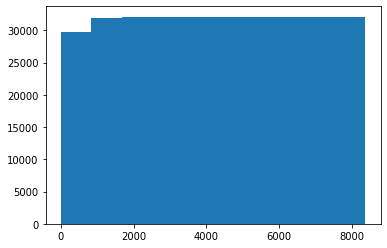

In [ ]:
np_length = np.zeros(len(sequences))
for i in range(len(sequences)):
  np_length[i] = len(sequences[i])

plt.hist(np_length, cumulative=True)

We see that although the maximum length is 8375, it belongs to a very small portion of outlier.  Our model will be unnecessarily heavy if we try to pad every occurrence to this.

Let's try to use the 90-percentile instead.

In [ ]:
import math
max_len = np.quantile(np_length, 0.9)
max_len = int(math.ceil(max_len / 100.0)) * 100
max_len

800

In [ ]:
# Pad the sequences to be fed into the neural network
train_sequences_padded = pad_sequences(sequences, maxlen=max_len)

In [ ]:
# Vocabulary defined in the word index
word_index = tokenizer.word_index
print(f'Length of tokenized words: {len(word_index)}')

# Create reverse index for lookup, and add a key for <PAD>
word_index_reverse = {v:k for k,v in word_index.items()}
word_index_reverse[0] = pad_tok

Length of tokenized words: 119764


In [ ]:
print(dict(list(word_index.items())[:20]))
print(dict(list(word_index_reverse.items())[:20]))

{'<OOV>': 1, 'the': 2, 'to': 3, 'of': 4, 'a': 5, 'and': 6, 'in': 7, 'that': 8, 's': 9, 'on': 10, 'for': 11, 'is': 12, 'said': 13, 'he': 14, 'it': 15, 'trump': 16, 'with': 17, 'was': 18, 'as': 19, 'by': 20}
{1: '<OOV>', 2: 'the', 3: 'to', 4: 'of', 5: 'a', 6: 'and', 7: 'in', 8: 'that', 9: 's', 10: 'on', 11: 'for', 12: 'is', 13: 'said', 14: 'he', 15: 'it', 16: 'trump', 17: 'with', 18: 'was', 19: 'as', 20: 'by'}


In [ ]:
print(type(train_sequences_padded))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [ ]:
for i in range(5):
  print(len(train_sequences_padded[i]))

800
800
800
800
800


# Model definition

In [ ]:
embed_dim = 50
lstm_out = 64
batch_size = 32
dropout = 0.3
n_epochs = 10

model = Sequential()
model.add(Embedding(vocab_size, embed_dim, input_length = max_len))
model.add(LSTM(lstm_out))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid', name='out_layer'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 800, 50)           250000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
Total params: 296,337
Trainable params: 296,337
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(train_sequences_padded, y_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

Epoch 1/10
804/804 [==============================] - 116s 145ms/step - loss: 0.1314 - accuracy: 0.9475 - val_loss: 0.0457 - val_accuracy: 0.9847
Epoch 2/10
804/804 [==============================] - 116s 145ms/step - loss: 0.0430 - accuracy: 0.9858 - val_loss: 0.0915 - val_accuracy: 0.9781
Epoch 3/10
804/804 [==============================] - 116s 145ms/step - loss: 0.0470 - accuracy: 0.9844 - val_loss: 0.0593 - val_accuracy: 0.9819
Epoch 4/10
804/804 [==============================] - 116s 145ms/step - loss: 0.0146 - accuracy: 0.9955 - val_loss: 0.0574 - val_accuracy: 0.9863
Epoch 5/10
804/804 [==============================] - 118s 147ms/step - loss: 0.0141 - accuracy: 0.9960 - val_loss: 0.4034 - val_accuracy: 0.8677
Epoch 6/10
804/804 [==============================] - 118s 147ms/step - loss: 0.0270 - accuracy: 0.9907 - val_loss: 0.0489 - val_accuracy: 0.9872
Epoch 7/10
804/804 [==============================] - 118s 147ms/step - loss: 0.0093 - accuracy: 0.9977 - val_loss: 0.2568 -

In [ ]:
# Validate on the test set
test_sequences = tokenizer.texts_to_sequences(X_test.values)
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len)

In [ ]:
model.evaluate(test_sequences_padded, y_test)

335/335 [==============================] - 16s 48ms/step - loss: 0.0530 - accuracy: 0.9823


[0.05301736667752266, 0.9823496341705322]

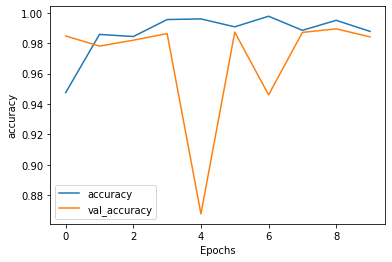

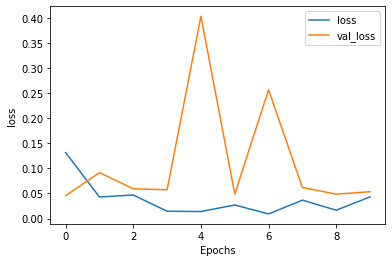

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Check against an out-of-set data


In [ ]:
def get_model_prediction(model, input_text, max_len):
  """ Returns a probability between 0 to 1 on whether the input string is
  fake (0) or real (0)

  input_text: str
  returns: float
  """

  sequence = tokenizer.texts_to_sequences([input_text])
  sequence_padded = pad_sequences(sequence, maxlen=max_len)
  return model.predict(sequence_padded)

#test_string = [text_train[0]]
test_string_CNN = """Brisbane, Australia (CNN)Every day, the men unfurl large pleas for help over the balcony railings of their hotel room and stand in silence as traffic roars along the main road of the Australian city they're trapped in.

Their signs are mostly made from bin bags stuck together with tape, and secured to the railing with shoelaces.
"Where is justice?" one reads.
These men are not hotel guests, but refugees and asylum seekers who have been in Australian immigration custody for seven years. Many arrived in Australian waters in 2013, after the government introduced offshore immigration processing. They were detained on the remote islands of Manus in Papua New Guinea (PNG) and on Nauru in the Pacific, in conditions once described by the United Nations as "harsh" and "inadequate." In 2016, Amnesty International called Nauru an "open-air prison."
"""

# Replace only the attribution to check the effect of the training data bias
test_string_Reuters = """Brisbane, Australia (Reuters)Every day, the men unfurl large pleas for help over the balcony railings of their hotel room and stand in silence as traffic roars along the main road of the Australian city they're trapped in.

Their signs are mostly made from bin bags stuck together with tape, and secured to the railing with shoelaces.
"Where is justice?" one reads.
These men are not hotel guests, but refugees and asylum seekers who have been in Australian immigration custody for seven years. Many arrived in Australian waters in 2013, after the government introduced offshore immigration processing. They were detained on the remote islands of Manus in Papua New Guinea (PNG) and on Nauru in the Pacific, in conditions once described by the United Nations as "harsh" and "inadequate." In 2016, Amnesty International called Nauru an "open-air prison."
"""

print(test_string_CNN)
print(test_string_Reuters)

result_CNN = get_model_prediction(model, test_string_CNN, max_len)
result_Reuters = get_model_prediction(model, test_string_Reuters, max_len)
print(f'With original attribution (CNN): {result_CNN}')
print(f'Altered attribution to Reuters: {result_Reuters}')

Brisbane, Australia (CNN)Every day, the men unfurl large pleas for help over the balcony railings of their hotel room and stand in silence as traffic roars along the main road of the Australian city they're trapped in.

Their signs are mostly made from bin bags stuck together with tape, and secured to the railing with shoelaces.
"Where is justice?" one reads.
These men are not hotel guests, but refugees and asylum seekers who have been in Australian immigration custody for seven years. Many arrived in Australian waters in 2013, after the government introduced offshore immigration processing. They were detained on the remote islands of Manus in Papua New Guinea (PNG) and on Nauru in the Pacific, in conditions once described by the United Nations as "harsh" and "inadequate." In 2016, Amnesty International called Nauru an "open-air prison."

Brisbane, Australia (Reuters)Every day, the men unfurl large pleas for help over the balcony railings of their hotel room and stand in silence as tra

# Slight bias
As you can see, there is still a very heavy bias even though all the text are the same and extracted from CNN (which reduces the effect of style of writing).  By simply changing the tag to Reuters (which was appearing in all the training data), the model was biased to that result (somewhat as expected)

While this sample showed negligible differences, some runs had shown the prediction to be at 0.56 for the original article and close to 0.99 by changing the tag to Reuters.

## Lessons learnt
It is important in training our models that we do not inadvertently bias the model through our own inputs.  While this case may be very obvious, and the results hardly surprising, are we putting in the right due diligence in making sure that we do not introduce gender, race, or demographic discrimination into our models?

# Double-check by cleaning up the data set.  We repeat the entire code above, with minimal text block explanations this time.

In [ ]:
df[df.labels == 1].head()

,title,text,subject,date,labels
13598,South Korea says Japan's Abe considering atten...,SEOUL (Reuters) - Japanese Prime Minister Shin...,worldnews,"November 29, 2017",1
7462,Iran says Trump should stay committed to the n...,BEIRUT (Reuters) - U.S. President-elect Donald...,politicsNews,"November 9, 2016",1
6197,Tensions rise at North Dakota pipeline as Trum...,"CANNON BALL, N.D. (Reuters) - Tensions have in...",politicsNews,"January 19, 2017",1
7592,Clinton holds slim lead over Trump in presiden...,WASHINGTON (Reuters) - Democrat Hillary Clinto...,politicsNews,"November 3, 2016",1
21206,French foreign minister to travel to Libya to ...,PARIS (Reuters) - France s foreign minister sa...,worldnews,"August 31, 2017",1


In [ ]:
# We remove the state name and (Reuters) as the Fake news sample does not start with that phrase.  This should then result in a clean comparison.
clean_df = df.copy()
clean_df['text'] = clean_df['text'].str.replace('^.*?\(Reuters\)\s*-\s*', '', regex=True)

In [ ]:
print(clean_df[clean_df.labels == 1].head())
print(clean_df[clean_df.labels == 0].head())

                                                   title  ... labels
13598  South Korea says Japan's Abe considering atten...  ...      1
7462   Iran says Trump should stay committed to the n...  ...      1
6197   Tensions rise at North Dakota pipeline as Trum...  ...      1
7592   Clinton holds slim lead over Trump in presiden...  ...      1
21206  French foreign minister to travel to Libya to ...  ...      1

[5 rows x 5 columns]
                                                   title  ... labels
6919    Civil Rights Legend Switches Endorsement And ...  ...      0
21393  Unreal! Senior Veteran Randomly Attacked Repea...  ...      0
13858  THE MOST CORRUPT WOMAN IN POLITICS Calls Trump...  ...      0
14174  TWO “HIGH THREAT” EXPLOSIVE Experts Moved From...  ...      0
13865  RELIGION OF PROGRESSIVISM: Meet Obama’s NEW Tr...  ...      0

[5 rows x 5 columns]


In [ ]:
# Obtain the train and test sets
features = df['text']
labels = df['labels']

X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state = 727)

print(f'Training Data: {X_train.shape}')
print(f'Test Data: {X_test.shape}')

Training Data: (32124,)
Test Data: (10708,)


In [ ]:
train_sequences_clean = tokenizer.texts_to_sequences(X_train.values)
train_sequences_padded_clean = pad_sequences(train_sequences_clean, maxlen=max_len)

In [ ]:
embed_dim = 50
lstm_out = 64
batch_size = 32
dropout = 0.3
n_epochs = 10

model_clean = Sequential()
model_clean.add(Embedding(vocab_size, embed_dim, input_length = max_len))
model_clean.add(LSTM(lstm_out))
model_clean.add(Dense(256, activation='relu'))
model_clean.add(Dropout(0.3))
model_clean.add(Dense(1, activation='sigmoid', name='out_layer'))
model_clean.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(model_clean.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 800, 50)           250000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
Total params: 296,337
Trainable params: 296,337
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history_clean = model_clean.fit(train_sequences_padded_clean, y_train, epochs=n_epochs, batch_size=batch_size, validation_split=0.2, verbose=1)

Epoch 1/10
804/804 [==============================] - 116s 145ms/step - loss: 0.1264 - accuracy: 0.9533 - val_loss: 0.0827 - val_accuracy: 0.9723
Epoch 2/10
804/804 [==============================] - 115s 143ms/step - loss: 0.0646 - accuracy: 0.9772 - val_loss: 0.0396 - val_accuracy: 0.9904
Epoch 3/10
804/804 [==============================] - 115s 143ms/step - loss: 0.0364 - accuracy: 0.9881 - val_loss: 0.2468 - val_accuracy: 0.9303
Epoch 4/10
804/804 [==============================] - 115s 143ms/step - loss: 0.0240 - accuracy: 0.9928 - val_loss: 0.0393 - val_accuracy: 0.9913
Epoch 5/10
804/804 [==============================] - 116s 144ms/step - loss: 0.0419 - accuracy: 0.9870 - val_loss: 0.0577 - val_accuracy: 0.9818
Epoch 6/10
804/804 [==============================] - 119s 148ms/step - loss: 0.0368 - accuracy: 0.9876 - val_loss: 0.0295 - val_accuracy: 0.9928
Epoch 7/10
804/804 [==============================] - 119s 149ms/step - loss: 0.0141 - accuracy: 0.9960 - val_loss: 0.0391 -

In [ ]:
# Validate on the test set
test_sequences = tokenizer.texts_to_sequences(X_test.values)
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len)

In [ ]:
model.evaluate(test_sequences_padded, y_test)

335/335 [==============================] - 17s 52ms/step - loss: 0.0530 - accuracy: 0.9823


[0.05301736667752266, 0.9823496341705322]

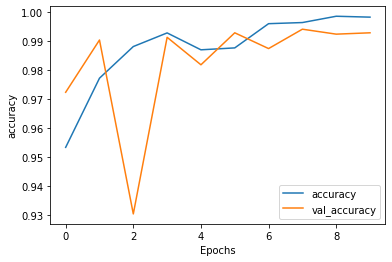

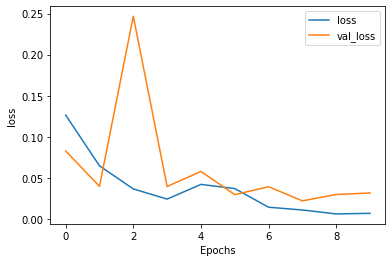

In [ ]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history_clean, "accuracy")
plot_graphs(history_clean, "loss")

In [ ]:
print(test_string_CNN)
print(test_string_Reuters)

result_CNN = get_model_prediction(model_clean, test_string_CNN, max_len)
result_Reuters = get_model_prediction(model_clean, test_string_Reuters, max_len)
print(f'With original attribution (CNN): {result_CNN}')
print(f'Altered attribution to Reuters: {result_Reuters}')

Brisbane, Australia (CNN)Every day, the men unfurl large pleas for help over the balcony railings of their hotel room and stand in silence as traffic roars along the main road of the Australian city they're trapped in.

Their signs are mostly made from bin bags stuck together with tape, and secured to the railing with shoelaces.
"Where is justice?" one reads.
These men are not hotel guests, but refugees and asylum seekers who have been in Australian immigration custody for seven years. Many arrived in Australian waters in 2013, after the government introduced offshore immigration processing. They were detained on the remote islands of Manus in Papua New Guinea (PNG) and on Nauru in the Pacific, in conditions once described by the United Nations as "harsh" and "inadequate." In 2016, Amnesty International called Nauru an "open-air prison."

Brisbane, Australia (Reuters)Every day, the men unfurl large pleas for help over the balcony railings of their hotel room and stand in silence as tra

### Much more consistent results after neutralizing the data points